density_matrix of (|0> + |1>)/sqrt(2) cross (|0> + |1>)/sqrt(2): 
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]] 

Hamiltonian:
   (1) [Y0]
+ (1) [Y1] 

circuit_density_matrix_init:
 [[0.25+0.00000000e+00j 0.25-3.92523115e-17j 0.25-3.92523115e-17j 0.25-7.85046229e-17j]
 [0.25+3.92523115e-17j 0.25+0.00000000e+00j 0.25+0.00000000e+00j 0.25-3.92523115e-17j]
 [0.25+3.92523115e-17j 0.25+0.00000000e+00j 0.25+0.00000000e+00j 0.25-3.92523115e-17j]
 [0.25+7.85046229e-17j 0.25+3.92523115e-17j 0.25+3.92523115e-17j 0.25+0.00000000e+00j]]

fidelity: 1.0000000099871134


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pennylane/math/quantum.py:46: UserWarning: Argument passed to fidelity has shape (4, 4) and will be interpreted as a density matrix. If a batched state vector was intended, please call qml.math.dm_from_state_vector first, as passing state vectors to fidelity is deprecated.
  warnings.warn(


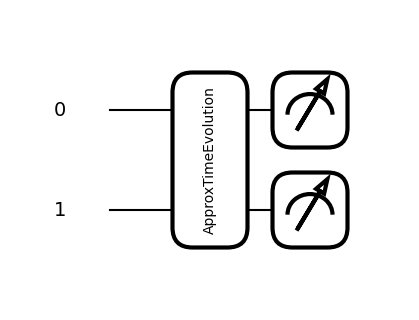

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
import scipy as sp

from pennylane import numpy as np
from IPython.display import display, Math

np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions()

dev = qml.device('default.qubit', wires= 2)

pauli_y = np.array([ [0, -1.j], [1.j, 0]])

# Calculate density matrix of rho_tot
# state = (00 + 01 + 10 + 11)/2
state_tot = np.kron( (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) , (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) )
rho_tot = state_tot @ state_tot.conj().T

print('density_matrix of (|0> + |1>)/sqrt(2) cross (|0> + |1>)/sqrt(2): \n', rho_tot,'\n')



# Hamiltonian setup
coeffs = [1, 1]
# obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
# obs = [qml.PauliX(0) , qml.PauliX(1)]
obs = [qml.PauliY(0) , qml.PauliY(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)
print('Hamiltonian:\n', hamiltonian,'\n')


# Quantum circuit
@qml.qnode(dev)
def circuit(theta_1, theta_2, tau):
    
	# """
	# qml.RX(theta_1,  wires = 0)    
	# qml.RX(theta_1, wires = 1)    
	# qml.RX(np.pi/2, wires = 0)    
	# qml.RX(np.pi/2, wires = 1)    
	
	qml.ApproxTimeEvolution(hamiltonian, tau, 1)
 
	
	# qml.RX(theta_2, wires = 0)    
	# qml.RX(theta_2, wires = 1) 
 
	# qml.RY(np.pi/2, wires = 0)    
	# qml.RY(np.pi/2, wires = 1)
	
	# """
 
	"""
	qml.Hadamard(wires=0) 
	qml.CNOT(wires=[0,1])
 	"""
	

	# return qml.state()
	return qml.density_matrix(wires=[0, 1])


# Calculate concurrence
def concurrence_calculation(paras):

	theta_1, theta_2, tau = paras
 
	# density matrix casting to numpy
	rho = circuit(theta_1, theta_2, tau).numpy()
 
	rho_tensor = rho.reshape([2,2,2,2])
	rho_reduced = np.trace(rho_tensor, axis1 = 0, axis2 = 2)
 
	concurrence = np.sqrt(2*(1-np.trace(rho_reduced**2)))

	# 1-concurrence = minimum => concurrence = max!!
	return 1 - concurrence


def fidelity_calculation(rho_1, rho_2):

    # fidelity = np.trace(rho_1 @ rho_2)
    # fidelity = np.linalg.norm(( sp.linalg.sqrtm(rho_1) @ sp.linalg.sqrtm(rho_2) ) ,2) **2
    # fidelity = np.trace( np.absolute( sp.linalg.sqrtm(rho_1) @ sp.linalg.sqrtm(rho_2) ))**2
    
    fidelity = (np.trace(sp.linalg.sqrtm( sp.linalg.sqrtm(rho_1) @ rho_2 @ sp.linalg.sqrtm(rho_1))))**2
    
    return fidelity.real

# theta_1 ,theta_2, tau
print('circuit_density_matrix_init:\n',circuit(0,0,np.pi/4))

print('\nfidelity:', qml.math.fidelity(rho_tot, circuit(0,0,np.pi/4)))
fig, ax = qml.draw_mpl(circuit)(0,0,1)

In [2]:
# Calculate the bell state density 

# == Test before optimize(concurrence) ==
# theta_1, theta_2, tau
test = 1,1,1
print('Concurrence before optimization: ', -1*(concurrence_calculation(test)-1) ,'\n')

# fidelity_calculation(rho_tot, rho_before)
rho_before = circuit(1,1,1)
print('fidelity before optimize: ',qml.math.fidelity(rho_tot, rho_before))

Concurrence before optimization:  (0.9092974268256816-0j) 

fidelity before optimize:  0.9113541867025495


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pennylane/math/quantum.py:46: UserWarning: Argument passed to fidelity has shape (4, 4) and will be interpreted as a density matrix. If a batched state vector was intended, please call qml.math.dm_from_state_vector first, as passing state vectors to fidelity is deprecated.
  warnings.warn(


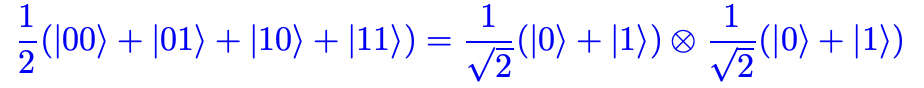

In [3]:
#== Optimze begin ==

Init_parameters = 1,1,1
result = sp.optimize.minimize(concurrence_calculation, Init_parameters, method='SLSQP')
# BFGS

# 1-concurrence = x => concurrence = -(x-1)
# -1 * concurrence = x  => concurrence = -1 * (x)
print('concurrence_after_optimize(max): ', -1 * (concurrence_calculation(result.x)-1) ,'\n')


# density matrix after optimze the circuit
rho_after_optimized = circuit(result.x[0], result.x[1],result.x[2]).numpy()

# print out parameters
print('optimized parameters:', result.x[0],result.x[1],result.x[2],'\n')

# print fidelity of optimized circuit
print('fidelity_after_optimzed:',qml.math.fidelity(rho_after_optimized, rho_tot))



concurrence_after_optimize(max):  (0.9999997531058307-0j) 

optimized parameters: 1.0 1.0 0.7857495137780474 

fidelity_after_optimzed: 0.9999997671557539


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,
